In [141]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from astropy.time import Time
import astropy.units as u
from astropy.visualization import time_support

import photutils

from fass.ser import load_ser_file
from fass.analyze_cube import find_apertures, moments, seeing, analyze_dimm_cube

time_support(simplify=True)

<astropy.visualization.time.time_support.<locals>.MplTimeConverter at 0x7f3240f72ef0>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [158]:
plt.close('all')

In [116]:
testfile = "/home/tim/MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-48-58.ser"
d = load_ser_file(testfile)

/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [148]:
testfile = "/home/tim/MMT/FASS/data/indi_2022-08-29/indi_record_2022-08-29@05-48-13.ser"
ave_seeing, seeing_vals, baselines, apertures, frame_times, fig = analyze_dimm_cube(testfile, plot=False)
ave_seeing

/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/home/tim/conda/envs/fass/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


<Quantity 1.88443295 arcsec>

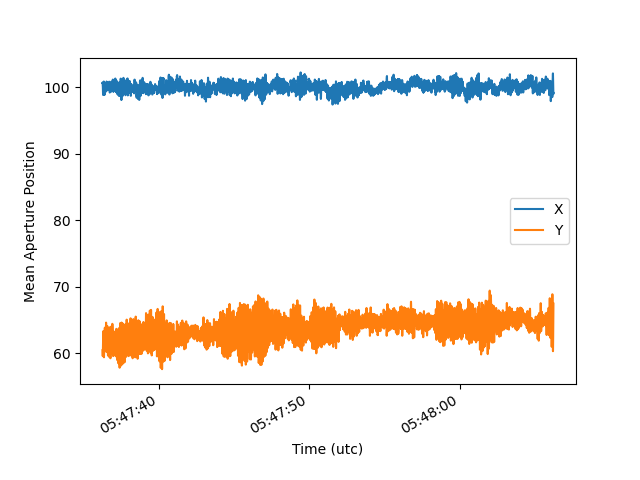

In [147]:
fig, ax = plt.subplots()
ax.plot(frame_times, apertures[0], label='X')
ax.plot(frame_times, apertures[1], label='Y')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Mean Aperture Position")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

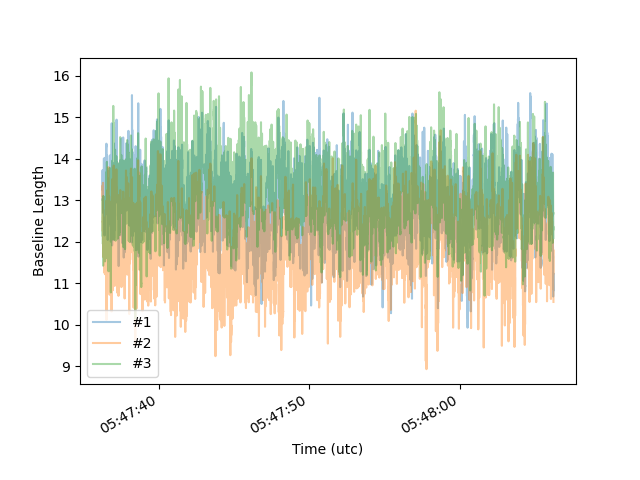

In [151]:
fig, ax = plt.subplots()
ax.plot(frame_times, baselines[0], label='#1', alpha=0.4)
ax.plot(frame_times, baselines[1], label='#2', alpha=0.4)
ax.plot(frame_times, baselines[2], label='#3', alpha=0.4)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_ylabel("Baseline Length")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

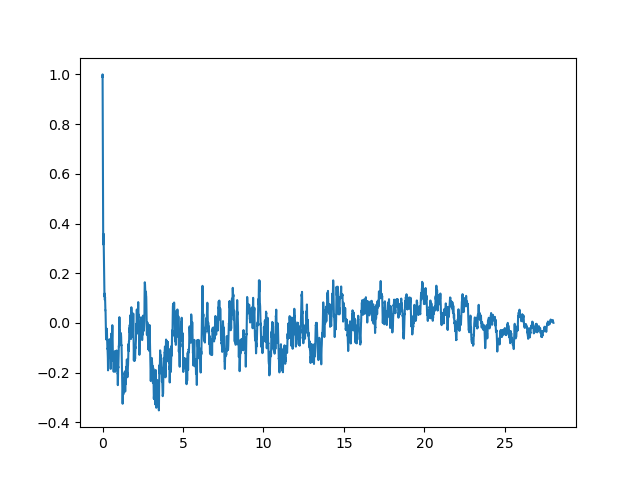

In [168]:
b0 = baselines[0] - baselines[0].mean()
b1 = baselines[1] - baselines[1].mean()
b2 = baselines[2] - baselines[2].mean()
dt = (frame_times[1] - frame_times[0]).to_value('sec')
autocor = np.correlate(b0, b2, mode='full')
autocor = autocor[autocor.size // 2 :]
fig = plt.figure()
plt.plot(dt * np.arange(autocor.size), autocor/autocor.max())
plt.show()

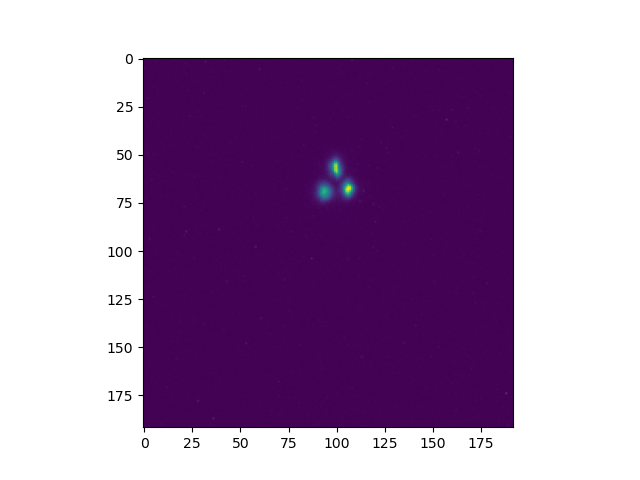

In [4]:
plt.imshow(d['data'][0:50, :, :].sum(axis=0))
#plt.imshow(d['data'][2, :, :]) # - d['data'][0, :, :])
plt.show()

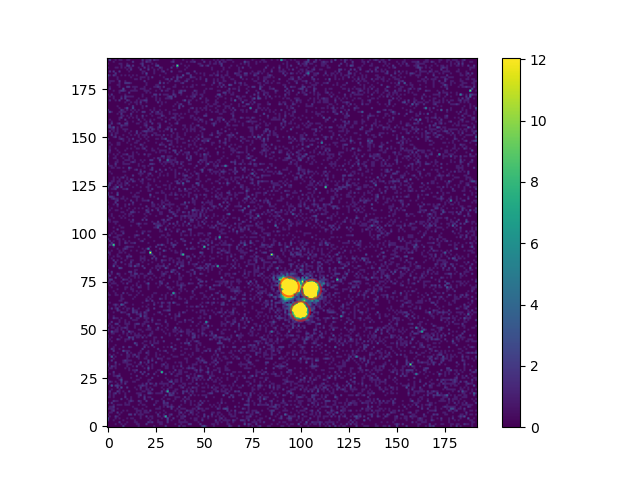

In [31]:
a, fig = find_apertures(d['data'][0:1, :, :].sum(axis=0), plot=True)

In [49]:
a.r

5.0

In [35]:
s = photutils.ApertureStats(d['data'][0, :, :], a)

In [50]:
pos = s.centroid
pos

array([[105.49335548,  70.96137874],
       [ 99.81157708,  59.82988777],
       [ 94.22289157,  72.20401606]])

In [39]:
a2 = photutils.CircularAperture(s.centroid, r=5)
a2

<CircularAperture([[105.49335548,  70.96137874],
                 [ 99.81157708,  59.82988777],
                 [ 94.22289157,  72.20401606]], r=5.0)>

In [64]:
def dimm_calc(data, aps):
    s = photutils.ApertureStats(data, aps)
    ap_pos = s.centroid
    new_aps = photutils.CircularAperture(ap_pos, aps.r)
    base1 = ap_pos[1] - ap_pos[0]
    base2 = ap_pos[2] - ap_pos[0]
    base3 = ap_pos[2] - ap_pos[1]
    d_base1 = np.sqrt(np.dot(base1.T, base1))
    d_base2 = np.sqrt(np.dot(base2.T, base2))
    d_base3 = np.sqrt(np.dot(base3.T, base3))
    return new_aps, [d_base1, d_base2, d_base3]

In [65]:

dimm_calc(d['data'][0, :, :], a)

(<CircularAperture([[105.7854512 ,  70.38167587],
                  [100.10680272,  59.31564626],
                  [ 94.41117851,  71.43934142]], r=5.0)>,
 [12.438008682327906, 11.42334169926124, 13.394928874611411])

In [66]:
nframes = d['data'].shape[0]
nframes

16108

In [67]:
baselines = []
for i in range(nframes):
    a, b = dimm_calc(d['data'][i, :, :], a)
    baselines.append(b)

In [71]:
baselines = np.array(baselines).transpose()

In [76]:
seeing(baselines[0].std()), seeing(baselines[1].std()), seeing(baselines[2].std())

(<Quantity 2.01034187 arcsec>,
 <Quantity 1.91497594 arcsec>,
 <Quantity 2.01094171 arcsec>)

In [113]:
a.positions.mean(axis=0)

array([100.87133442,  65.40467687])

In [112]:
a.positions

array([[106.94124337,  68.60803639],
       [101.02678571,  57.56112637],
       [ 94.64597419,  70.04486785]])